# 2. Scenario Discovery & PRIM
## 2.1 Installing EMA workbench and importing libraries

In [1]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)

import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt

## 2.2 Scenario Discovery
In this section, scenario discovery is applied to identify policies that minimize Expected Annual Damage and water level (min, max), and their robustness is tested

In [17]:
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

levers = copy.deepcopy(dike_model.levers)

for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000026249DB94E0>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000026249DB94E0>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000026249DB94E0>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000026249DB94E0>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

The experiments are run with 1,000 scenarios and 10 policies 

In [18]:
ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 1000
policies = 10

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios, policies)

experiments, outcomes = results


[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|██████████████████████████████████| 10000/10000 [1:38:51<00:00,  1.69it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### 3.2.1 Worst Case Analysis

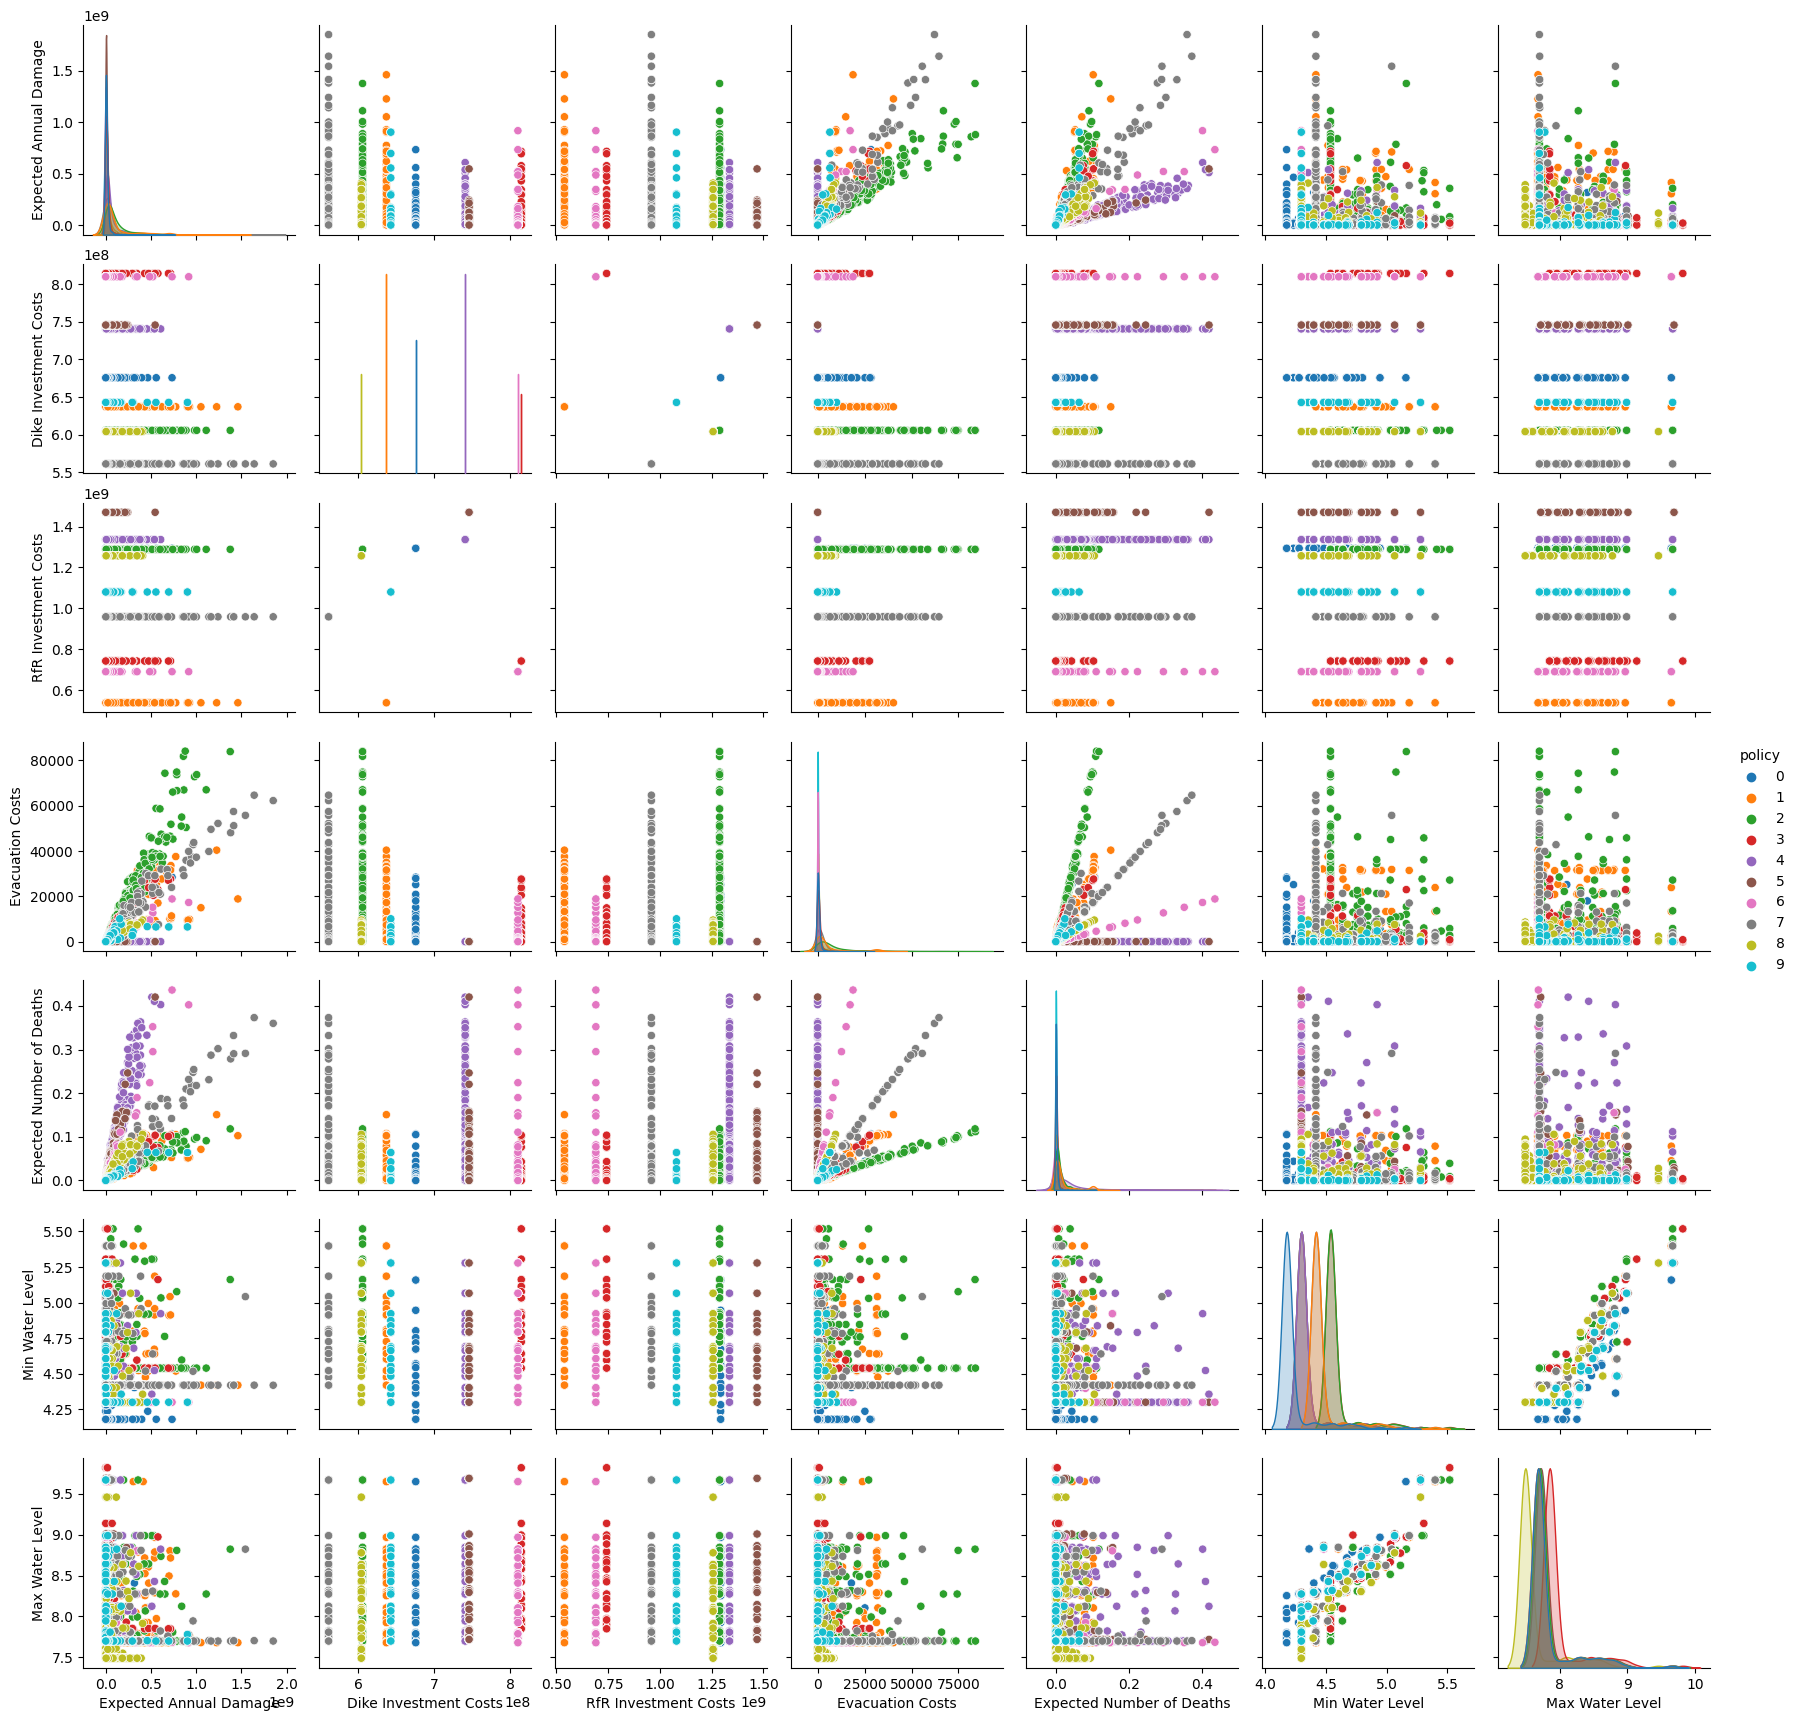

In [19]:

policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
plt.show()

Interpretation: 

1- The uncertainty space for min water level rise can be significantly reduced for certain policies. 
2- EAD uncertainty space is relatively small in all cases, the absolute decrease potential is important 
3- A higher min water level rise does not correlate to a higher EAD. **This suggests a dampening effect by, for example,  dike increases**

Next, the policies with worse EAD than the BAU scenario are sought. 

To identify policies with better and worse EAD performance, a subspace partitioning excercise will be performed. 
First, the EAD and water level values for the BAU scenario are identified:

In [20]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_adj = [
    Policy(
        "BAU",
        **dict(
            get_do_nothing_dict()
        )
    )
]

ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 200

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_bau = evaluator.perform_experiments(scenarios, policies_adj)

experiments_bau, outcomes_bau = results_bau

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
100%|████████████████████████████████████████| 200/200 [01:18<00:00,  2.55it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [21]:
print(pd.DataFrame(outcomes_bau).describe([.25,.5,.75,.90,.95]))

       Expected Annual Damage  Dike Investment Costs  RfR Investment Costs   
count            2.000000e+02                  200.0                 200.0  \
mean             1.521101e+09                    0.0                   0.0   
std              9.708361e+08                    0.0                   0.0   
min              9.046370e+07                    0.0                   0.0   
25%              5.989119e+08                    0.0                   0.0   
50%              1.643010e+09                    0.0                   0.0   
75%              2.285142e+09                    0.0                   0.0   
90%              2.765496e+09                    0.0                   0.0   
95%              3.127060e+09                    0.0                   0.0   
max              3.957181e+09                    0.0                   0.0   

       Evacuation Costs  Expected Number of Deaths  Min Water Level   
count             200.0                 200.000000       200.000000  \

Taking the mean as a BAU scenario, the following values can be assumed: 
1. EAD = 1.5 B EUR 
2. Min Water Level Rise: 4.5 m 
3. Max Water Level Rise: 8.35m 

To ensure the quality of the policies and minimize potential damages, the confidence interval chosen is 95%. 
Through this, we identify the outcomes that meet the following criteria: 

1. EAD < 3.1843 
2. Min water level rise > 4.8070
3. The spread between min and max water level can be interpreted as a potential increase in profit for the Transport     Company. Therefore, the preferred water level spread is > 4.3480 (preferred water spread = max water level rise - min water level rise, or 9.1551 - 4.8070) 


In [22]:
outcomes_df = pd.DataFrame(outcomes)

experiments_df = pd.DataFrame(experiments)

cleaned_experiments = experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)#.drop(labels=['policy','model','scenario'],axis=1)


In [25]:
outcomes_df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Min Water Level,Max Water Level
0,0.000000e+00,6.755423e+08,1.293500e+09,0.000000,0.000000,4.178700,7.678167
1,0.000000e+00,6.755423e+08,1.293500e+09,0.000000,0.000000,4.568816,8.615526
2,1.365334e+07,6.755423e+08,1.293500e+09,792.812746,0.003201,4.178700,8.253797
3,4.944214e+06,6.755423e+08,1.293500e+09,229.907802,0.000500,4.178700,7.678137
4,0.000000e+00,6.755423e+08,1.293500e+09,0.000000,0.000000,4.362898,8.825475
...,...,...,...,...,...,...,...
9995,0.000000e+00,6.427669e+08,1.080100e+09,0.000000,0.000000,4.792693,8.735484
9996,0.000000e+00,6.427669e+08,1.080100e+09,0.000000,0.000000,4.298700,7.699981
9997,0.000000e+00,6.427669e+08,1.080100e+09,0.000000,0.000000,4.521746,8.427703
9998,8.423164e+06,6.427669e+08,1.080100e+09,98.558865,0.000972,4.298700,7.698112


In [26]:
data = outcomes_df['Min Water Level']

y = data[data < 4.807055]

data.describe([.25,.5,.75,.95,.99])

count    10000.000000
mean         4.413071
std          0.195062
min          4.178145
25%          4.298700
50%          4.298700
75%          4.538700
95%          4.798812
99%          5.161764
max          5.518257
Name: Min Water Level, dtype: float64

Interpretation: In most cases, the minimum water level rise is lower than the value defined previously. An adjustment is then made for the objective of the water level, taking the value for a 90% confidence interval, the new value is **4.7027** 



In [27]:
y = np.array(data < 4.702725)

In [28]:
from ema_workbench.analysis import prim


prim_alg = prim.Prim(cleaned_experiments, y, threshold=0.8)


box1 = prim_alg.find_box()


#print(type(y))

C:\Users\Federico\Anaconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 9298 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1428, coverage: 0.15358141535814154, density: 1.0 restricted_dimensions: 9


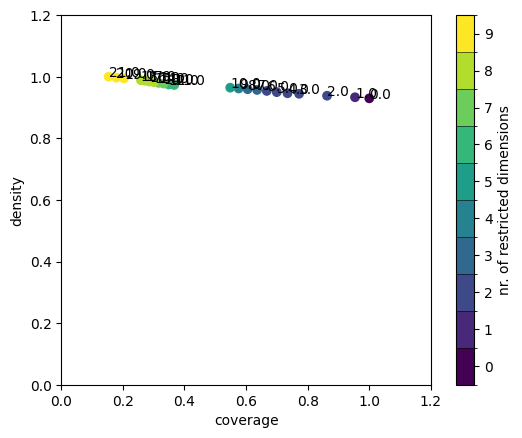

In [30]:
box1.show_tradeoff(annotated=True)

plt.show()

Interpretation:  
With increased coverage of data points in the box identified by PRIM, the higher the box is representable for the whole dataset. The lower the density value, the proportion of interesting events within it are lower. 

Therefore, we set the following rules: Density > 60% & Coverage > 70% 
For this, box 14 is selected

In [31]:
point = 14
box1.inspect(point)

coverage     0.316197
density      0.980000
id          14.000000
mass         0.300000
mean         0.980000
res_dim      7.000000
Name: 14, dtype: float64

                             box 14                                           
                                min                       max      qp value   
A.2_Bmax                  30.054699                322.246912           NaN  \
A.5_Bmax                  87.621046                333.959558  2.171863e-07   
A.2_Brate               {10.0, 1.0}               {10.0, 1.0}  4.616507e-06   
policy     {0, 1, 4, 5, 6, 7, 8, 9}  {0, 1, 4, 5, 6, 7, 8, 9}  8.096641e-05   
A.3_pfail                  0.053661                  0.955078  9.897086e-04   
A.1_Bmax                  44.467977                349.798173  6.452594e-02   
A.4_pfail                  0.052496                  0.999247  3.173387e-01   

                     
           qp value  
A.2_Bmax   0.034697  
A.5_Bmax   0.001874  
A.2_Brate       NaN  
policy          NaN 

[None]

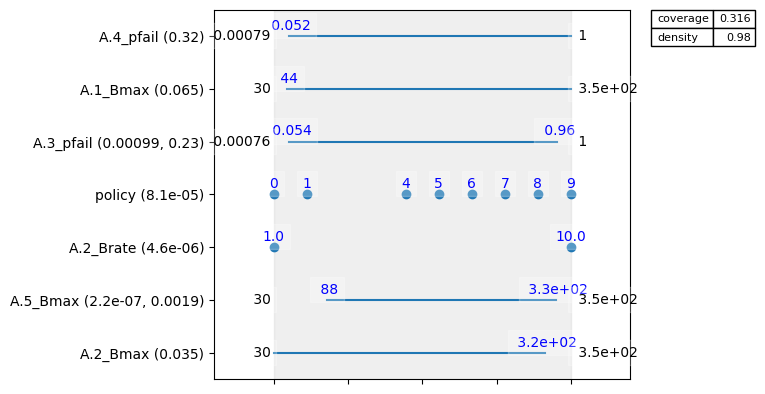

In [32]:
box1.inspect(point,style='graph')
plt.show()

Interpretation: This figure shows the complete inverval for each parameter. 
The blue line shows the interval of the box identified by PRIM for RealParameters. A dot is used for Categorical Parameters. 
From this, the following can be concluded: 
1. None of the uncertainties are excludable. However, policies 1, 4, 8 and 9 are identified to have a low water level. 
2. Lacking statistical significance for the influence of failure probablities 


C:\Users\Federico\Anaconda3\envs\MBDM\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


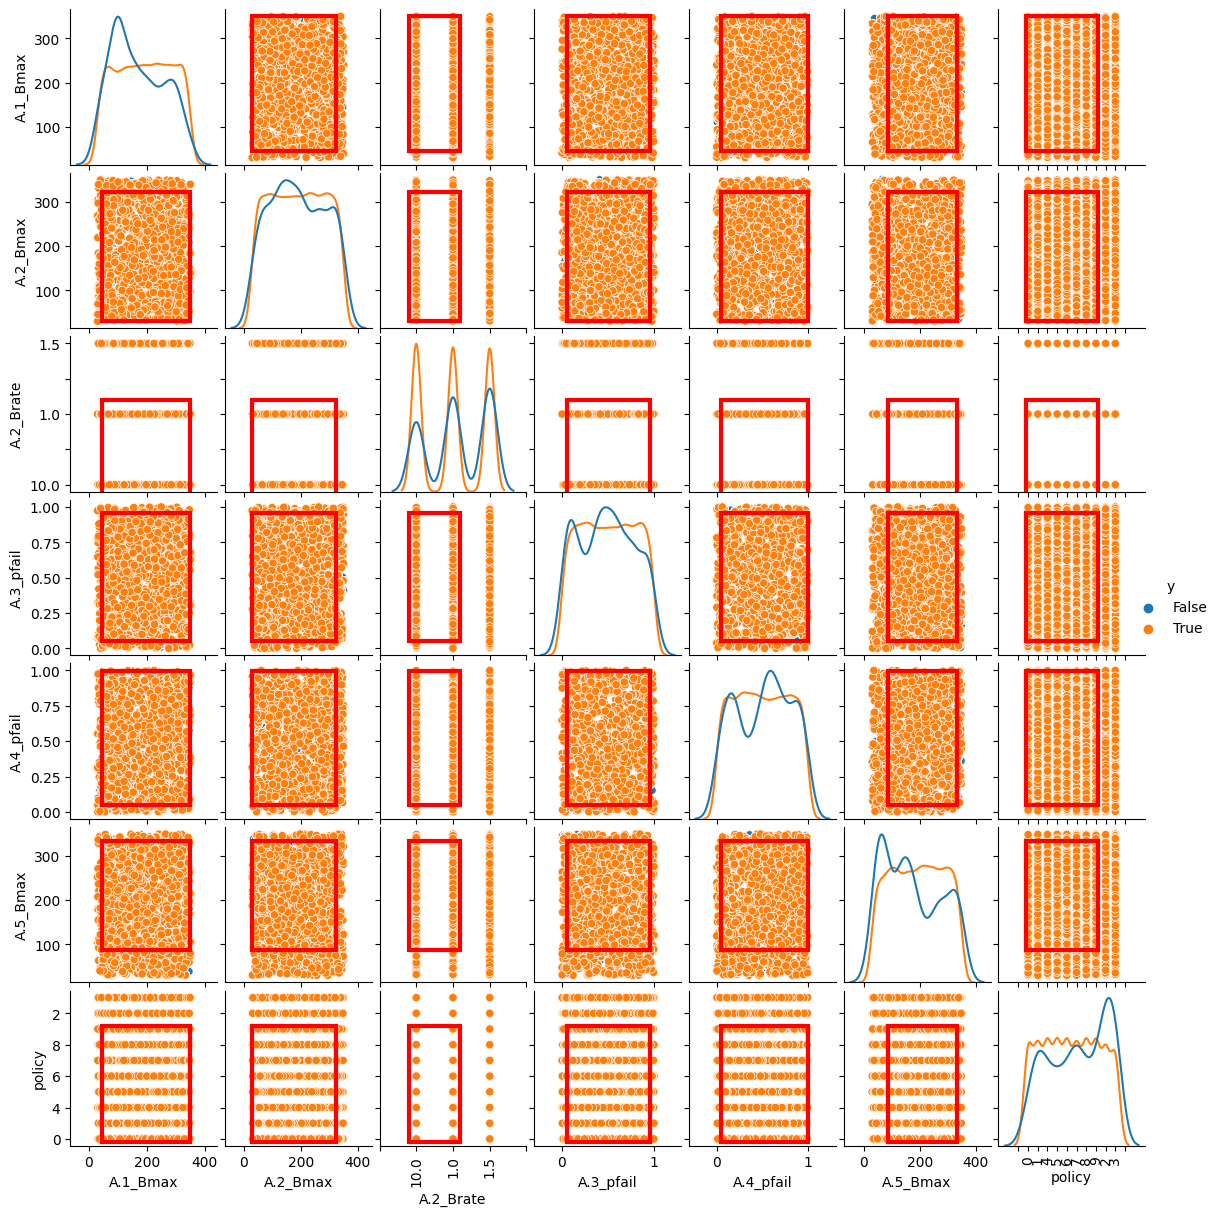

In [33]:
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

Interpretation: It can be concluded that lower water levels result in higher failure probability

[MainProcess/INFO] model dropped from analysis because only a single category


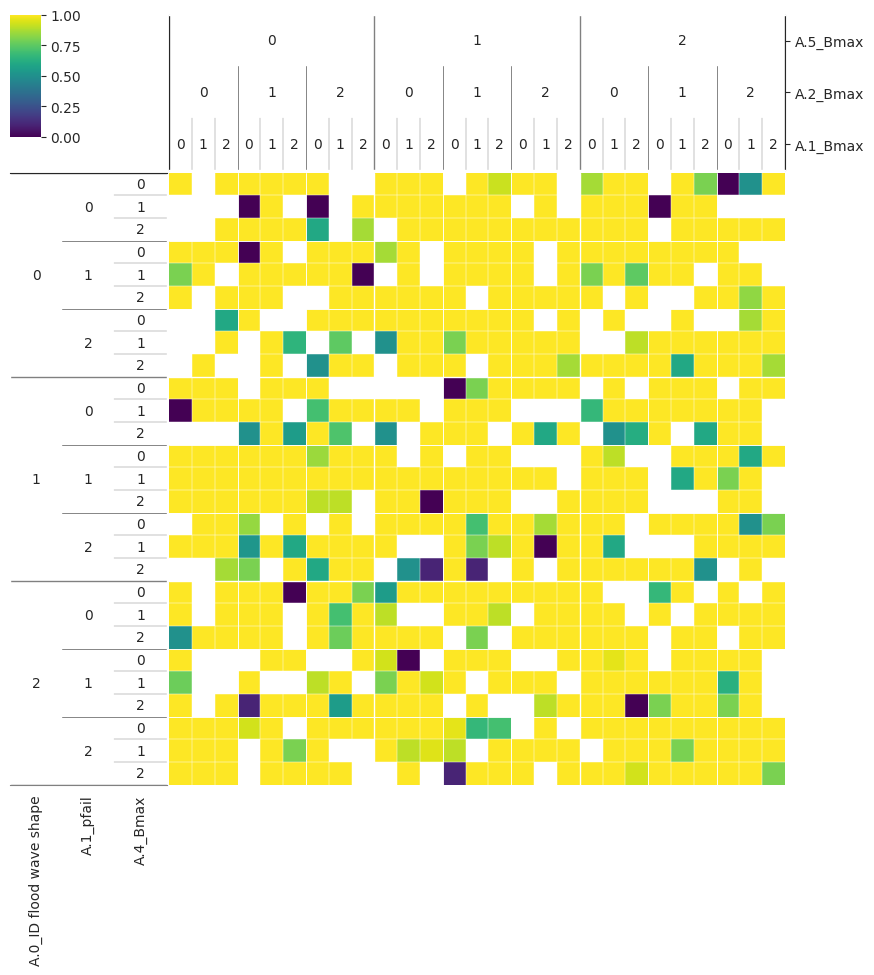

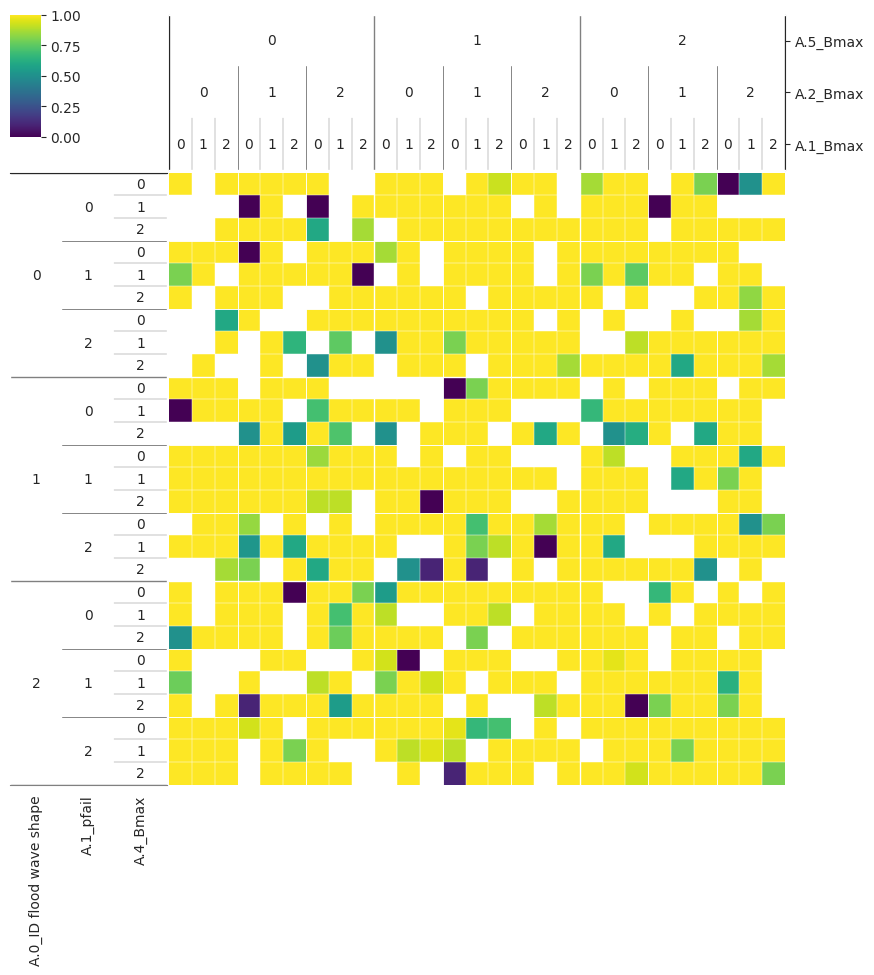

In [34]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments, y)

Interpretation: 
1. Gaps indicate the need for a bigger sampling size, which will provide an increase in statistical significance. 
2. Adjusting the minimum water level could also be beneficial as it decreases the sampling size 


In [35]:
ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 1000
policies = 10

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_resam = evaluator.perform_experiments(scenarios, policies)

experiments_resam, outcomes_resam = results_resam



[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|██████████████████████████████████| 10000/10000 [1:46:55<00:00,  1.56it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [36]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
import numpy as np
import pandas as pd
import copy
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

levers = copy.deepcopy(dike_model.levers)

We aim to find the conditions in lever and uncertainty space that enable a higher water level than BAU scenario. 
Experience has shown that a higher number of scenarios is needed to improve convergence, so the value is set at 4,000 scenarios, with 10 policies. 

In [37]:
ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 4000
policies = 10

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_b = evaluator.perform_experiments(scenarios, policies)

experiments_b, outcomes_b = results_b

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 4000 scenarios * 10 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [4:28:04<00:00,  2.49it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [39]:
experiments_df_b = pd.DataFrame(experiments_b)
outcomes_df_b = pd.DataFrame(outcomes_b)

cleaned_experiments_b = experiments_df_b.drop(labels=[l.name for l in dike_model.levers],
                                          axis=1)

data_b = outcomes_df_b['Min Water Level']


#y_b = np.array(data_b < 2.85)

data_b.describe([.25, .5, .75, .95, .99])



count    40000.000000
mean         4.404163
std          0.171089
min          4.178130
25%          4.298700
50%          4.418700
75%          4.418700
95%          4.726372
99%          5.056716
max          5.496054
Name: Min Water Level, dtype: float64

In [40]:
y_b = np.array(data_b < 4.807055) #should be 4?

Previously, the target min water level rise value (for BAU) was identified as 4.807. This lands in between the 95 and 99% confidence intervals, which would indicate only a 5% probability of a higher water level. 
To define a realistic target, an external source was consulted. The Rijkswaterstaat indicates a minimum water level of 285 cm for the IJssel river (Rijkswaterstaat, 2023). In figure 1, the minimum water depth for river shipping classes is presented. Taking a CEMT Klasse of VIa as the optimal solution for the Transport Company, a minimum water level of 4m can be deemed acceptable. 

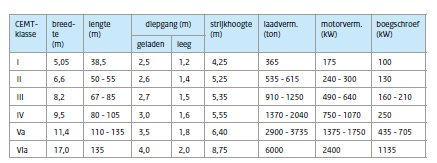 
  
<center><i>Figure 1 - Table showing mininum water level by river shipping classes (Rijkswaterstaat, 2020) </center></i>

The following section will then use this value to calculate a second worst-case scenario


### 3.2.2 Worst Case 2 

In [41]:
from ema_workbench.analysis import prim


prim_alg = prim.Prim(cleaned_experiments_b, y_b, threshold=0.8)

box2 = prim_alg.find_box()


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40000 points remaining, containing 38436 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.081875, coverage: 0.08520657716723905, density: 1.0 restricted_dimensions: 10


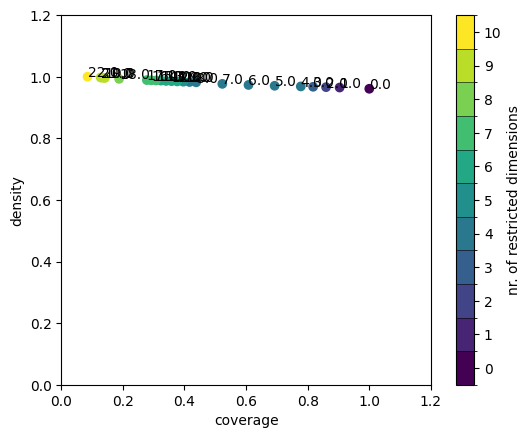

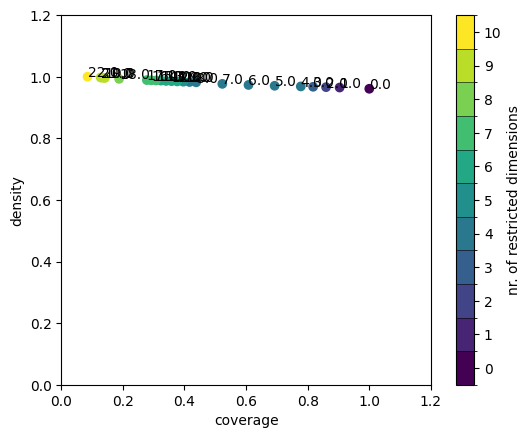

In [42]:
box2.show_tradeoff(annotated=True)

In [43]:
point = 7
box2.inspect(point)

coverage    0.522869
density     0.976815
id          7.000000
mass        0.514350
mean        0.976815
res_dim     4.000000
Name: 7, dtype: float64

                                          box 7   
                                            min   
A.5_pfail                              0.000167  \
A.2_Bmax                              30.004483   
policy     {2222, 2223, 2224, 2227, 2228, 2229}   
A.4_Bmax                              46.010621   

                                                                         
                                            max      qp value  qp value  
A.5_pfail                              0.950663           NaN  0.131845  
A.2_Bmax                             334.060709           NaN  0.148020  
policy     {2222, 2223, 2224, 2227, 2228, 2229}  5.368188e-24       NaN  
A.4_Bmax                             349.975586  1.397669e-01       NaN  



[None]

In [44]:
point = 8
box2.inspect(point)

coverage    0.437949
density     0.981802
id          8.000000
mass        0.428625
mean        0.981802
res_dim     4.000000
Name: 8, dtype: float64

                                    box 8                                   
                                      min                             max   
A.2_Bmax                        30.004483                      334.060709  \
A.5_pfail                        0.000167                        0.950663   
policy     {2222, 2223, 2224, 2227, 2228}  {2222, 2223, 2224, 2227, 2228}   
A.4_Bmax                        46.010621                      349.975586   

                                   
               qp value  qp value  
A.2_Bmax            NaN  0.145711  
A.5_pfail           NaN  0.148030  
policy     6.409501e-41       NaN  
A.4_Bmax   1.859371e-01       NaN  



[None]

In [45]:
point = 10
box2.inspect(point)

coverage     0.395983
density      0.983840
id          10.000000
mass         0.386750
mean         0.983840
res_dim      5.000000
Name: 10, dtype: float64

                                   box 10                                   
                                      min                             max   
A.5_pfail                        0.000167                        0.950663  \
A.3_pfail                         0.00003                        0.949916   
policy     {2222, 2223, 2224, 2227, 2228}  {2222, 2223, 2224, 2227, 2228}   
A.2_Bmax                        44.969398                      334.060709   
A.4_Bmax                        46.010621                      349.975586   

                                   
               qp value  qp value  
A.5_pfail           NaN  0.140447  
A.3_pfail           NaN  0.184352  
policy     1.989125e-41       NaN  
A.2_Bmax   1.321891e-01  0.096650  
A.4_Bmax   2.773864e-01       NaN  



[None]

[<Figure size 640x480 with 1 Axes>]

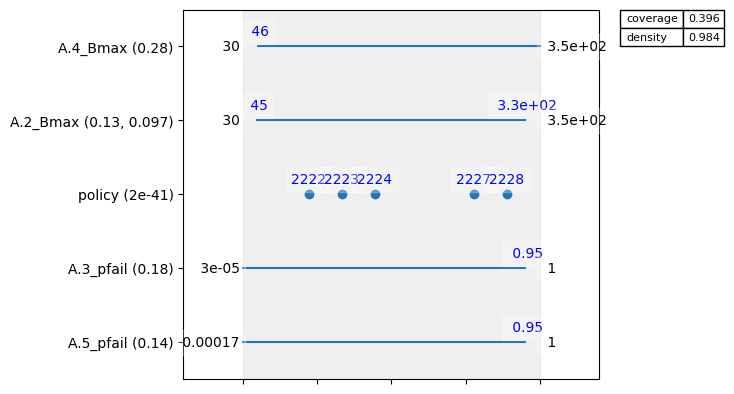

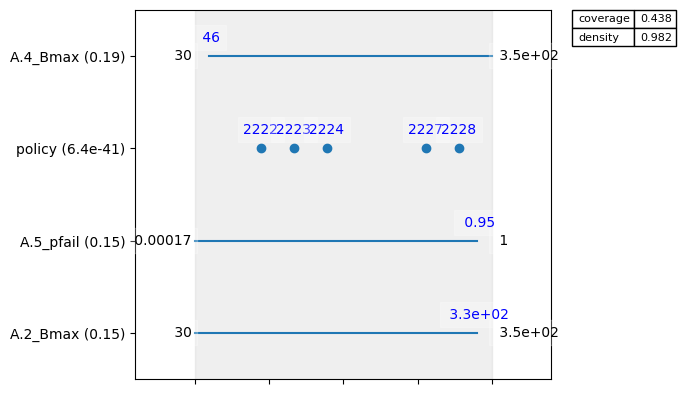

In [46]:
box2.inspect(point,style='graph')
box2.inspect(8,style='graph')

Interpretation: 

1. All policies except for 7 and 9 correspond to the worst cases
2. A.1_pfail is plays an important role in water level 


In [47]:
filter_df = experiments_df_b[experiments_df_b['policy'].isin([0, 1, 2, 3, 4, 5, 6, 8])]
columns_range = filter_df.loc[:, '0_RfR 0':'EWS_DaysToThreat']  # Select the desired columns range
filter_df.drop_duplicates(subset=columns_range.columns, keep='first', inplace=True)

filter_df.drop(filter_df.columns[:filter_df.columns.get_loc('discount rate 2')+1], axis=1, inplace=True)

filter_df.to_excel('worst case policy.xlsx')
#filter_df

C:\Users\Federico\AppData\Local\Temp\ipykernel_6036\2648901816.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df.drop(filter_df.columns[:filter_df.columns.get_loc('discount rate 2')+1], axis=1, inplace=True)


The worst policies are extracted and can be used during the policy debate by the Transport Company to ensure that they are avoided

In [48]:

def get_stat_par(outcomes, policies):
    pol_dict = {}

    for policy in policies.cat.categories:
        pol_dict[policy] = pd.DataFrame(columns=outcomes.columns)

        # Filter outcomes for the current policy
        policy_outcomes = outcomes.loc[policies == policy]

        # Calculate statistical parameters for each outcome using describe()
        describe_stats = policy_outcomes.describe([.1,.25,.50,.75,.90,.95,.99])
        pol_dict[policy] = describe_stats

    return pol_dict

stat_par_dict=get_stat_par(outcomes_df_b, experiments_df_b['policy'])

# Create an empty list to store the dataframes
dfs = []

# Iterate over the policies and populate the list of dataframes
for policy, describe_stats in stat_par_dict.items():
    # Add a new level to the index for the policy
    describe_stats.index = pd.MultiIndex.from_product([[policy], describe_stats.index])
    # Append the describe_stats dataframe to the list
    dfs.append(describe_stats)

# Concatenate the dataframes in the list into a single dataframe with multi-index
df_multi_index = pd.concat(dfs)

# Print the resulting multi-index dataframe
df_multi_index


Expected Annual Damage  Dike Investment Costs   
2220 count            4.000000e+03           4.000000e+03  \
     mean             9.708682e+07           5.953521e+08   
     std              1.435905e+08           2.384484e-07   
     min              0.000000e+00           5.953521e+08   
     10%              6.806805e+06           5.953521e+08   
...                            ...                    ...   
2229 75%              1.000853e+07           8.314046e+08   
     90%              2.651551e+07           8.314046e+08   
     95%              4.003879e+07           8.314046e+08   
     99%              8.415196e+07           8.314046e+08   
     max              1.830804e+09           8.314046e+08   

            RfR Investment Costs  Evacuation Costs  Expected Number of Deaths   
2220 count          4.000000e+03       4000.000000                4000.000000  \
     mean           5.696000e+08       6701.040149                   0.013719   
     std            0.000000e+00       9109.524584                   0.021764   
     min            5.696000e+08          0.000000                   0.000000   
     10%            5.696000e+08        434.264820                   0.001070   
...                          ...               ...                        ...   
2229 75%            1.146000e+09          0.000000                   0.007007   
     90%            1.146000e+09          0.000000                   0.016113   
     95%            1.146000e+09          0.000000                   0.035531   
     99%            1.146000e+09          0.000000                   0.139636   
     max            1.146000e+09          0.000000                   2.560742   

            Min Water Level  Max Water Level  
2220 count      4000.000000      4000.000000  
     mean          4.464165         7.802963  
     std           0.141128         0.316034  
     min           4.418130         7.678101  
     10%           4.418700         7.678109  
...                     ...              ...  
2229 75%           4.418700         7.529273  
     90%           4.569788         8.060270  
     95%           4.832164         8.397588  
     99%           5.056716         8.758448  
     max           5.376054         9.448307  

[120 rows x 7 columns]

In [49]:
df_multi_index.to_excel('worst case output.xlsx')

Interpretation: 
Even though the worst case outcomes are detected, and therefore worst case scenario discovery is completed, the uncertainties that cause unfavourable outcomes are still not identified 


[MainProcess/INFO] model dropped from analysis because only a single category


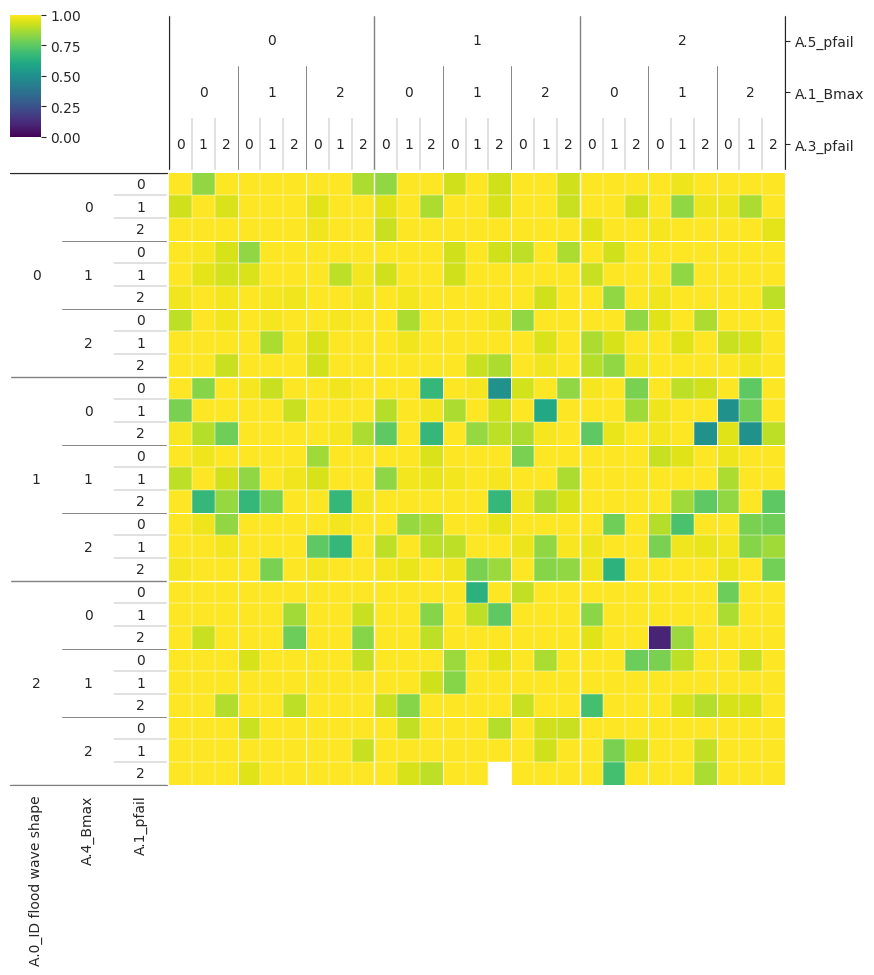

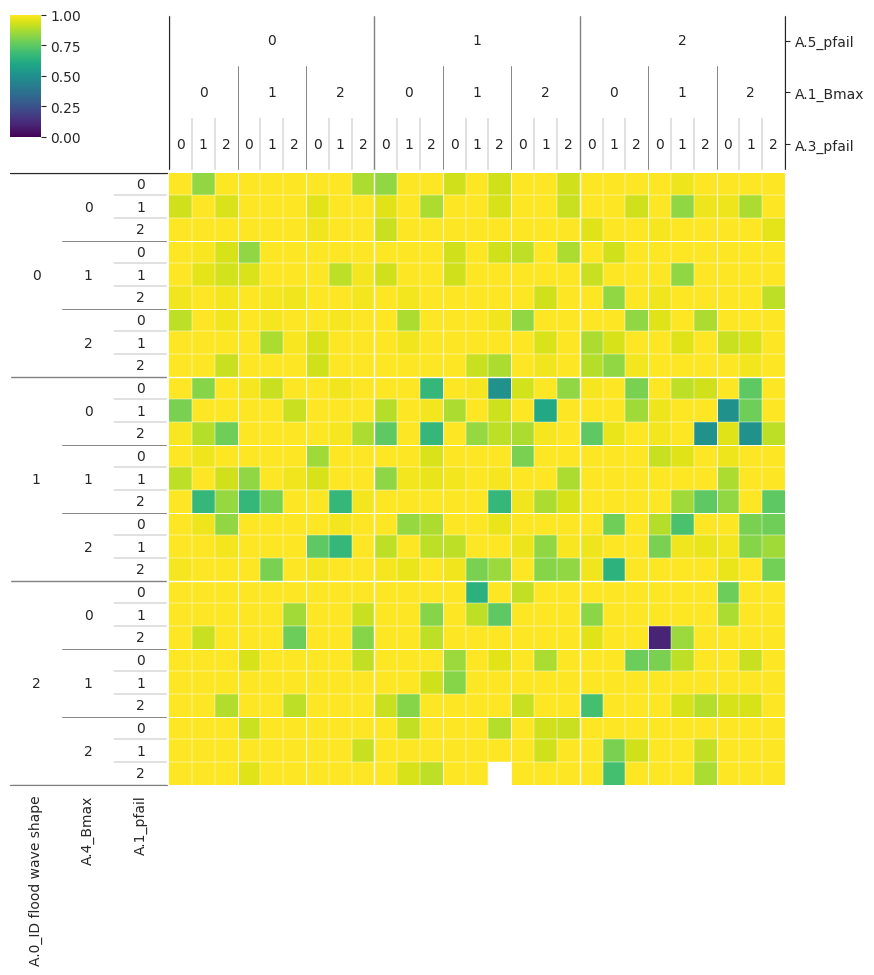

In [50]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(cleaned_experiments_b, y_b)

From this graph, it can be observed that some blank spaces still exist, which indicates that more experiments could be beneficial to increase confidence.


### 3.2.3 Best Case Analysis

In this section, the policies that create the best case scenario are identified. 
The best case is defined as a policy where: 
1. EAD < EAD BAU 
2. Minimum Water Level > 4.8070 


In [90]:
cleaned_experiments_b.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', 'scenario', 'policy', 'model'],
      dtype='object')

In [93]:

y_best = np.array(data_b > 4.807055)

prim_alg_best = prim.Prim(cleaned_experiments_b, y_best, threshold=0.8)

box3 = prim_alg_best.find_box()

box3.show_tradeoff(annotated=True)



[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40000 points remaining, containing 1564 cases of interest


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Interpretation: The analysis indicates that the density is lower than .5, which is why the best case scenario analysis is not performed 


In [94]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns
import matplotlib.pyplot as plt

x = experiments_df_b
y = outcomes_df_b.loc[:,['Min Water Level R','Expected Annual Damage']]

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()


KeyError: "['Min Water Level Rise'] not in index"

In [109]:
result_df = fs.agg(['max', 'idxmax']).T.rename(columns={'max': 'Max Value', 'idxmax': 'Max Index'})

result_df

,Max Value,Max Index
Min Water Level Rise,0.17721,3_RfR 0
Expected Annual Damage,0.280431,A.3_pfail


Interpretation: For a minimum water level rise, the lever 3_RfR 0 is highly relevant, with a value of 0.17721. 
For EAD, the failure rate of A.3_pfail is relevant 

These relevancies are identified using feature scoring.

In [110]:
from ema_workbench.analysis import RuleInductionType

x = experiments_df_b
y = outcomes_df_b.loc[:,['Min Water Level Rise']]<4.807055

fs = feature_scoring.get_feature_scores_all(x, y)

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\admin\Documents\GitHub\MBDM_Group5\venv\Lib\site-packages\ema_workbench\analysis\feature_scoring.py:334: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees.fit(x, y)


,1
0,
A.0_ID flood wave shape,0.122583
A.1_pfail,0.053561
A.5_pfail,0.049987
A.3_Bmax,0.048037
discount rate 0,0.046695
A.2_pfail,0.046646
A.2_Bmax,0.046326
A.4_Brate,0.045904
A.1_Bmax,0.045868


In [117]:
result_df = fs.agg(['max', 'idxmax']).T.rename(columns={'max': 'Max Value', 'idxmax': 'Max Index'})

fs

,1
0,
A.0_ID flood wave shape,0.122583
A.1_pfail,0.053561
A.5_pfail,0.049987
A.3_Bmax,0.048037
discount rate 0,0.046695
A.2_pfail,0.046646
A.2_Bmax,0.046326
A.4_Brate,0.045904
A.1_Bmax,0.045868


Interpretation: Through feature scoring, the uncertainty related to flood wave shape at A.0 (A.0_ID flood wave shape) is identified as the one with highest importance, followed by A.1 pfail and A.5 pfail. 

Therefore, it can be concluded that flood wave shape influences the flood peak, and therefore the water level. 
In case of failure rate, high dike failure rates affect the water level greatly.  


### 3.2.3 SEED DEFINITION

From the previous experiments, a seed scenario is sought for in order to identify rules for better assumptions. 



In [118]:
y_seed =  np.array(data_b < np.percentile(data_b,10))

prim_alg_seed = prim.Prim(cleaned_experiments_b, y_seed, threshold=0.8)

box3 = prim_alg_seed.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40000 points remaining, containing 182 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.07080350039777247, returning dump box


Interpretation: The 10th percentile causes the density to drop below acceptable levels. It is therefore required to define a seed from previous experiments. 
Using the findings from boxes 7, 8 and 10 derived from 3.2.2 Worst Case 2, the values can be leveraged and used to define a seed. The following data is used:   


<center><i>Table 1- PRIM values extracted for box 7</center></i>

| box 7     |                    |                    |              |          |
|-----------|--------------------|--------------------|--------------|----------|
|           | **min**            | **max**            | **qp value** |**qp value**  |
| A.1_pfail | 0.000009           | 0.903212           | NaN          | 0.00961  |
| policy    | {2, 3, 4, 5, 6, 8} | {2, 3, 4, 5, 6, 8} | 6.606195e-33 | NaN      |
| A.5_pfail | 0.050002           | 0.99977            | 9.489071e-02 | NaN      |
| and       |                    |                    |              |          |

<center><i>Table 2- PRIM values extracted for box 8</center></i>

| box 8     |                    |                    |              |          |
|-----------|--------------------|--------------------|--------------|----------|
|           | **min**            | **max**            | **qp value** |**qp value**  |
| A.1_pfail | 0.000009           | 0.903212           | NaN          | 0.017442 |
| policy    | {2, 3, 5, 6, 8}    | {2, 3, 5, 6, 8}    | 8.349920e-53 | NaN      |
| A.5_pfail | 0.050002           | 0.99977            | 9.078316e-02 | NaN      |

<center><i>Table 2- PRIM values extracted for box 10</center></i>

| box 10     |                    |                    |              |          |
|-----------|--------------------|--------------------|--------------|----------|
|           | **min**            | **max**            | **qp value** |**qp value**  |
| A.1_pfail | 0.000009           | 0.903212           | NaN          | 0.01111  |
| policy    | {2, 3, 5, 6, 8}    | {2, 3, 5, 6, 8}    | 3.115530e-53 | NaN      |
| A.5_pfail | 0.050002           | 0.99977            | 1.295964e-01 | NaN      |
| A.4_pfail | 0.050992           | 0.999975           | 1.901445e-01 | NaN      |
| A.3_Bmax  | 46.258871          | 349.932175         | 2.450915e-01 | NaN      |


Furthermore, from the previous experiment it is known that the most relevant uncertainties are:
- A.0_ID flood wave shape
- A.1_pfail
- A.5_pfail
- A.3_Bmax

For these parameters, the 75% confidence interval is used, in an attempt to maintain robustness against high values. 
Therefore, the seed is defined as follows: 

In [1]:
reference_scenario = Scenario('reference', **{'discount rate 0': 2.5, 
                                              'discount rate 1': 2.5,
                                              'discount rate 2': 2.5,
                                              'A.0_ID flood wave shape': 75,
                                              'A.1_Bmax': 190, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 190, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 190, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 190, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 190, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

NameError: name 'Scenario' is not defined

In [12]:
dict_1= {'discount rate 0': 2.5, 
                                              'discount rate 1': 2.5,
                                              'discount rate 2': 2.5,
                                              'A.0_ID flood wave shape': 75,
                                              'A.1_Bmax': 190, 'A.2_Bmax': 190,'A.3_Bmax': 190, 'A.4_Bmax': 190, 'A.5_Bmax': 190,
          
                                              'A.1_pfail': 0.5,'A.2_pfail': 0.5, 'A.3_pfail': 0.5,'A.4_pfail': 0.5, 'A.5_pfail': 0.5,
         'A.1_Brate': 1.5,
          'A.2_Brate': 1.5,                                   
         'A.3_Brate': 1.5,                                  
         'A.4_Brate': 1.5,                                  
          'A.5_Brate': 1.5}

In [13]:
pd.DataFrame.from_dict(dict_1, orient='index', columns=['Value'])

,Value
discount rate 0,2.5
discount rate 1,2.5
discount rate 2,2.5
A.0_ID flood wave shape,75.0
A.1_Bmax,190.0
A.2_Bmax,190.0
A.3_Bmax,190.0
A.4_Bmax,190.0
A.5_Bmax,190.0
A.1_pfail,0.5


## References

1.Rijkswaterstaat. (2023). Minst gepeilde diepten. Vaarweeg Informatie. https://www.vaarweginformatie.nl/frp/main/#/hydro/mgd  
2. Rijkswaterstaat (2020) Richtlijnen Vaarwegen, Rijkswaterstaat Water